In [1]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
#mount googledrive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
#dezipping
!unzip /content/gdrive/MyDrive/UofT/Project/SecondData/Augdata_split.zip -d my_data

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: my_data/Augdata_split/test/30kmh/Classimg4660.png  
  inflating: my_data/Augdata_split/test/30kmh/Classimg4795.png  
  inflating: my_data/Augdata_split/test/30kmh/Classimg4799.png  
  inflating: my_data/Augdata_split/test/30kmh/Classimg4804.png  
  inflating: my_data/Augdata_split/test/30kmh/Classimg4821.png  
  inflating: my_data/Augdata_split/test/30kmh/Classimg4822.png  
  inflating: my_data/Augdata_split/test/30kmh/Classimg4836.png  
  inflating: my_data/Augdata_split/test/30kmh/Classimg4844.png  
  inflating: my_data/Augdata_split/test/30kmh/Classimg4846.png  
  inflating: my_data/Augdata_split/test/30kmh/Classimg4964.png  
  inflating: my_data/Augdata_split/test/30kmh/Classimg4968.png  
  inflating: my_data/Augdata_split/test/30kmh/Classimg4976.png  
  inflating: my_data/Augdata_split/test/30kmh/Classimg4986.png  
  inflating: my_data/Augdata_split/test/30kmh/Classimg4993.png  
  inflating:

In [4]:
# location on Google Drive
master_path = '/content/my_data/Augdata_split/'

# Transform Settings - Do not use RandomResizedCrop
transform = transforms.Compose([transforms.Resize((224,224)), 
                                transforms.ToTensor()])

# assumes three folders with 60% training, 20% validation and 20% testing samples
train_dataset = torchvision.datasets.ImageFolder(master_path + 'train', transform=transform)
val_dataset = torchvision.datasets.ImageFolder(master_path + 'val', transform=transform)
test_dataset = torchvision.datasets.ImageFolder(master_path + 'test', transform=transform)

# Prepare Dataloader
batch_size = 32
num_workers = 1

In [31]:
class CNN_net(nn.Module):
    def __init__(self):
        super(CNN_net, self).__init__()
        self.name = "CNN_net"
        self.conv1 = nn.Conv2d(3, 10, 3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.pool2 = nn.MaxPool2d(3,3)
        self.conv2 = nn.Conv2d(10, 64, 3)
        self.conv3 = nn.Conv2d(64,64,4)
        self.conv4 = nn.Conv2d(64,128, 5)
        self.conv5 = nn.Conv2d(128,128, 3)
        self.fc1 = nn.Linear(128* 4*4, 10)
        self.fc2 = nn.Linear(10, 3)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool1(F.relu(self.conv2(x)))
        x = self.pool1(F.relu(self.conv3(x)))
        x = self.pool1(F.relu(self.conv4(x)))
        x = self.pool1(F.relu(self.conv5(x)))
        x = x.view(-1, 128 * 4* 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [32]:
from torchsummary import summary
summary(CNN_net(), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 10, 222, 222]             280
         MaxPool2d-2         [-1, 10, 111, 111]               0
            Conv2d-3         [-1, 64, 109, 109]           5,824
         MaxPool2d-4           [-1, 64, 54, 54]               0
            Conv2d-5           [-1, 64, 51, 51]          65,600
         MaxPool2d-6           [-1, 64, 25, 25]               0
            Conv2d-7          [-1, 128, 21, 21]         204,928
         MaxPool2d-8          [-1, 128, 10, 10]               0
            Conv2d-9            [-1, 128, 8, 8]         147,584
        MaxPool2d-10            [-1, 128, 4, 4]               0
           Linear-11                   [-1, 10]          20,490
           Linear-12                    [-1, 3]              33
Total params: 444,739
Trainable params: 444,739
Non-trainable params: 0
-------------------------------

In [7]:
def get_accuracy(model, data):
    correct = 0
    total = 0
    model.eval() #*********#
    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=64):
        output = model(imgs)
        pred = output.max(1, keepdim=True)[1] # get the index of the max logit
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [18]:
from tqdm import tqdm

In [33]:
def train(model, train_data, val_data,batch_size=64, num_epochs=1, lr= 0.005, momentum =0.9, weight_decay = 0.08, already_trained_iter = 0):

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay = weight_decay)

    iters, losses, train_acc, val_acc = [], [], [], []
    save_models = []
    # training
    n = 0 # the number of iterations
    print("num_epochs: ", num_epochs)
    for epoch in tqdm(range(num_epochs)):
        for imgs, labels in iter(train_loader):
              
            out = model(imgs)             # forward pass

            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

        # save the current training information
        iters.append(n)
        losses.append(float(loss)/batch_size)             # compute *average* loss
        train_acc.append(get_accuracy(model, train_data)) # compute training accuracy 
        val_acc.append(get_accuracy(model, val_data))  # compute validation accuracy
        save_models.append(model.state_dict())
        n += 1
        ## checkpointing
        print("Epoch {}: Train acc: {} | val acc: {}".format(
                epoch,
                train_acc[-1],
                val_acc[-1]))
            
    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    return save_models

In [34]:
model = CNN_net()
save_models = train(model, train_dataset,val_dataset, batch_size=32, num_epochs=15, lr= 0.01, momentum =0.1, weight_decay = 0.01)

num_epochs:  15


  7%|▋         | 1/15 [06:05<1:25:14, 365.34s/it]

Epoch 0: Train acc: 0.3216374269005848 | val acc: 0.3216374269005848


 13%|█▎        | 2/15 [12:19<1:20:15, 370.43s/it]

Epoch 1: Train acc: 0.3216374269005848 | val acc: 0.3216374269005848


 13%|█▎        | 2/15 [13:37<1:28:34, 408.79s/it]


KeyboardInterrupt: ignored

## Using Alexnet

In [35]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [36]:
classes = ["30kmh","NoRight","Stop"]
def compute_features_and_save(data_loader, path):

    """ The data_loader must have a batch size of 1"""


    n = 0
    for img, label in data_loader:
        #computing features
        features = alexnet.features(img)
        features_tensor = torch.from_numpy(features.detach().numpy())
        #saving the feature
        print(label)
        folder_path= path + '/' + str(classes[label])
        torch.save(features_tensor.squeeze(0), 
                   folder_path + '/' + str(n) + '.tensor')
        n += 1

In [37]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, 
                                           num_workers= 1, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size= 1, 
                                          num_workers= 1, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size= 1, 
                                          num_workers= 1, shuffle=True)

In [38]:
import os
os.mkdir("/content/gdrive/MyDrive/UofT/Project/SecondData/alexnet")
os.mkdir("/content/gdrive/MyDrive/UofT/Project/SecondData/alexnet/train")
os.mkdir("/content/gdrive/MyDrive/UofT/Project/SecondData/alexnet/val")
os.mkdir("/content/gdrive/MyDrive/UofT/Project/SecondData/alexnet/test")

In [40]:
for cl in classes:
    os.mkdir("/content/gdrive/MyDrive/UofT/Project/SecondData/alexnet/train/" + cl)
    os.mkdir("/content/gdrive/MyDrive/UofT/Project/SecondData/alexnet/val/" + cl)
    os.mkdir("/content/gdrive/MyDrive/UofT/Project/SecondData/alexnet/test/" + cl)

In [43]:
path = "/content/gdrive/MyDrive/UofT/Project/SecondData/alexnet/"
compute_features_and_save(train_loader, path + "train")
compute_features_and_save(val_loader,
                          path + "val")
compute_features_and_save(test_loader,
                          path + "test")

tensor([1])
tensor([2])
tensor([1])
tensor([0])
tensor([1])
tensor([0])
tensor([2])
tensor([1])
tensor([1])
tensor([1])
tensor([0])
tensor([2])
tensor([0])
tensor([0])
tensor([0])
tensor([0])
tensor([0])
tensor([0])
tensor([1])
tensor([1])
tensor([2])
tensor([0])
tensor([1])
tensor([0])
tensor([0])
tensor([1])
tensor([2])
tensor([1])
tensor([1])
tensor([2])
tensor([0])
tensor([2])
tensor([2])
tensor([1])
tensor([1])
tensor([2])
tensor([0])
tensor([0])
tensor([1])
tensor([2])
tensor([0])
tensor([2])
tensor([1])
tensor([0])
tensor([0])
tensor([1])
tensor([1])
tensor([2])
tensor([1])
tensor([0])
tensor([1])
tensor([1])
tensor([1])
tensor([2])
tensor([1])
tensor([2])
tensor([2])
tensor([0])
tensor([2])
tensor([1])
tensor([0])
tensor([1])
tensor([2])
tensor([2])
tensor([2])
tensor([0])
tensor([1])
tensor([1])
tensor([2])
tensor([0])
tensor([0])
tensor([1])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([1])
tensor([0])
tensor([0])
tensor([1])
tensor([0])
tensor([0])
tensor([0])
tens

In [44]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.name = "Classifier"
        self.conv1 = nn.Conv2d(256, 128,2)
        self.fc1 = nn.Linear(128* 5 * 5, 16)
        self.fc2 = nn.Linear(16,9)
        self.dropout1 = nn.Dropout(0.4) # drop out layer
        self.dropout2 = nn.Dropout(0.4)
        self.dropout3 = nn.Dropout(0.4)
    def forward(self, x):
        x = self.conv1(self.dropout1(x))
        x = x.view(-1, 128*5*5)
        x = F.relu(self.fc1(self.dropout2(x)))
        x = F.relu(self.fc2(self.dropout3(x)))
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [47]:
### Loading the data
path = "/content/gdrive/MyDrive/UofT/Project/SecondData/alexnet/"
train_data_alex = torchvision.datasets.DatasetFolder(path +"train",
                                                     loader=torch.load, 
                                                     extensions=('.tensor'))
val_data_alex = torchvision.datasets.DatasetFolder(path + "val", 
                                                   loader=torch.load, 
                                                   extensions=('.tensor'))
test_data_alex = torchvision.datasets.DatasetFolder(path + "test",
                                                    loader=torch.load,
                                                    extensions=('.tensor'))

num_epochs:  17


  6%|▌         | 1/17 [00:19<05:10, 19.42s/it]

Epoch 0: Train acc: 0.3216374269005848 | val acc: 0.3216374269005848


 12%|█▏        | 2/17 [00:38<04:47, 19.17s/it]

Epoch 1: Train acc: 0.48586744639376217 | val acc: 0.4678362573099415


 18%|█▊        | 3/17 [01:00<04:47, 20.56s/it]

Epoch 2: Train acc: 0.9171539961013645 | val acc: 0.9161793372319688


 24%|██▎       | 4/17 [01:19<04:16, 19.71s/it]

Epoch 3: Train acc: 0.9354288499025342 | val acc: 0.9298245614035088


 29%|██▉       | 5/17 [01:36<03:48, 19.07s/it]

Epoch 4: Train acc: 0.9680799220272904 | val acc: 0.9649122807017544


 35%|███▌      | 6/17 [01:55<03:28, 18.92s/it]

Epoch 5: Train acc: 0.9870857699805068 | val acc: 0.9805068226120858


 41%|████      | 7/17 [02:13<03:05, 18.57s/it]

Epoch 6: Train acc: 0.9980506822612085 | val acc: 0.9961013645224172


 47%|████▋     | 8/17 [02:31<02:46, 18.55s/it]

Epoch 7: Train acc: 0.9997563352826511 | val acc: 0.9980506822612085


 53%|█████▎    | 9/17 [02:49<02:26, 18.33s/it]

Epoch 8: Train acc: 1.0 | val acc: 1.0


 59%|█████▉    | 10/17 [03:08<02:08, 18.34s/it]

Epoch 9: Train acc: 1.0 | val acc: 1.0


 65%|██████▍   | 11/17 [03:27<01:50, 18.50s/it]

Epoch 10: Train acc: 1.0 | val acc: 1.0


 71%|███████   | 12/17 [03:45<01:32, 18.56s/it]

Epoch 11: Train acc: 1.0 | val acc: 1.0


 76%|███████▋  | 13/17 [04:04<01:14, 18.70s/it]

Epoch 12: Train acc: 1.0 | val acc: 1.0


 82%|████████▏ | 14/17 [04:23<00:55, 18.56s/it]

Epoch 13: Train acc: 1.0 | val acc: 1.0


 88%|████████▊ | 15/17 [04:41<00:37, 18.50s/it]

Epoch 14: Train acc: 1.0 | val acc: 1.0


 94%|█████████▍| 16/17 [04:59<00:18, 18.40s/it]

Epoch 15: Train acc: 1.0 | val acc: 1.0


100%|██████████| 17/17 [05:17<00:00, 18.69s/it]

Epoch 16: Train acc: 1.0 | val acc: 1.0


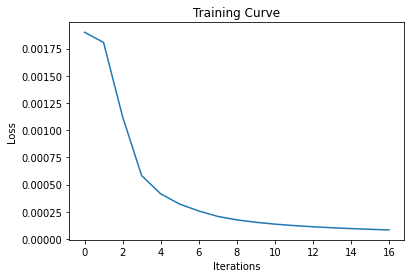

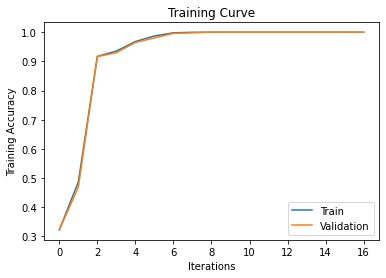

Final Training Accuracy: 1.0
Final Validation Accuracy: 1.0


In [50]:
classifier = Classifier()
models_save = train(classifier, train_data_alex, val_data_alex, batch_size=32,
      lr = 0.01, num_epochs=17,momentum =0.3, weight_decay = 0.001)

In [52]:
#getting the test accuracy

get_accuracy(classifier,test_data_alex)

1.0

In [55]:
prediction = []
labels_true = []
for imgs, labels in iter(test_data_alex):
    output = classifier(imgs)
    pred = output.max(1, keepdim=True)[1]
    pred = pred.detach().numpy()
    pred = pred[0][0]
    prediction += [pred]

    labels_true += [labels]

In [56]:
from sklearn.metrics import confusion_matrix

In [57]:
confusion_matrix(labels_true, prediction, labels= [i for i in range(3)])

array([[177,   0,   0],
       [  0, 171,   0],
       [  0,   0, 165]])

In [59]:
import pandas as pd
pd.crosstab(labels_true,prediction,rownames = ['True class'], colnames = ['Predicted class'])

Predicted class,0,1,2
True class,,,
0,177,0,0
1,0,171,0
2,0,0,165
